# Absorption line fitting

The supplied data file: j124257-7533_spectra.txt contains observational data from a radio telescope. This data contains absorption line features from neutral hydrogen (HI) in the Milky Way and continuum emission from a distant quasar that is used as "background light" for observing the HI in the Milky Way. We can assume that each gas cloud in our line of sight towards the background source produces a Gaussian absorption feature that is only dependent on the opical depth of the gas cloud. The higher the optical depth, the deeper the absorption feature. 

- This spectra is a bit noisy, so to find the two absorption features it is either neccesary to suply the model with preliminary guesses for the mean and the amplitude or to smooth the data. Initial guesses can be supplied to the modell the following way: Gaussian1D(amplitude=10.2, mean=2.3, stddev=1.2). For more details see: https://docs.astropy.org/en/stable/modeling/parameters.html


In [1]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.modeling import models, fitting
from astropy.modeling.models import Gaussian1D


In [8]:
# reading in the data from a text file

spectra = pd.read_csv('j124257-7533_spectra.txt', sep=' ')

In [9]:
spectra


,velocity,intensity
0,-100.000000,0.535824
1,-99.800000,0.480186
2,-99.600000,0.511209
3,-99.400000,0.473837
4,-99.200000,0.479554
...,...,...
995,99.000004,0.512582
996,99.200004,0.498250
997,99.400004,0.487952
998,99.600004,0.415036


In [10]:
spectra['velocity'][0]

-100.000000112

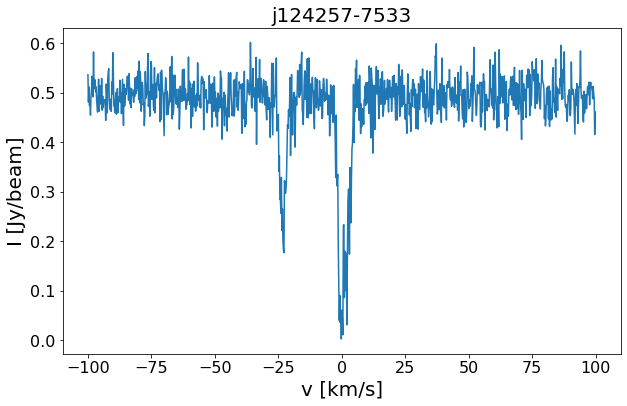

In [11]:
# Makeing a plot:

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra['intensity'])
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

In [12]:
# A very simple fit

pars = np.polyfit(spectra['velocity'], spectra['intensity'], 1)
print(pars)

[1.33326127e-05 4.79556882e-01]


In [13]:
pars

array([1.33326127e-05, 4.79556882e-01])

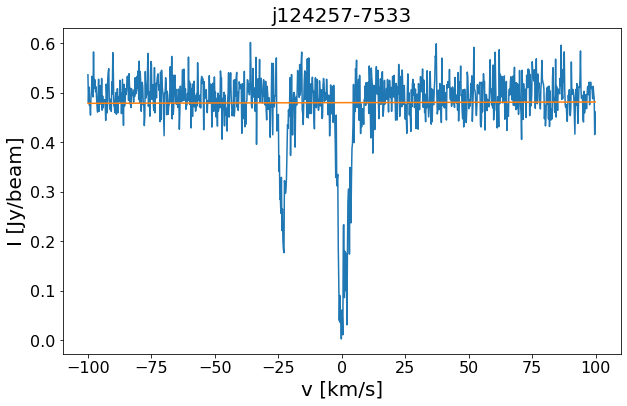

In [14]:
# plotting the fit

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra['intensity'])
plt.plot(spectra['velocity'], spectra['velocity']*pars[0]+pars[1])
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

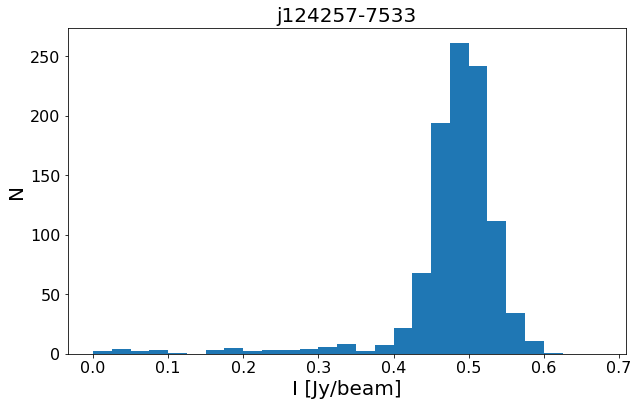

In [15]:
# A better fit can be achived with masking the absorption lines
# first, let us find a good data range for the mask

# Makeing a plot:

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.hist(spectra['intensity'], bins=np.arange(0,0.7,0.025))
ax.set_ylabel(r'N', fontsize=20)
ax.set_xlabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

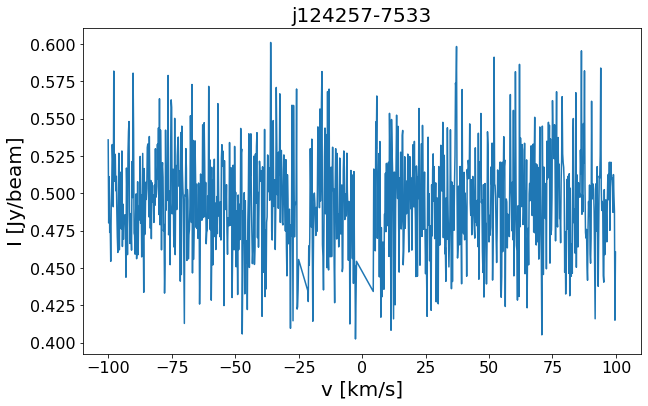

In [16]:
# masking the data

spectra_masked = spectra[spectra['intensity'] > 0.4]


# Makeing a plot:

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra_masked['velocity'], spectra_masked['intensity'])
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

[-1.03823654e-05  4.93592421e-01]


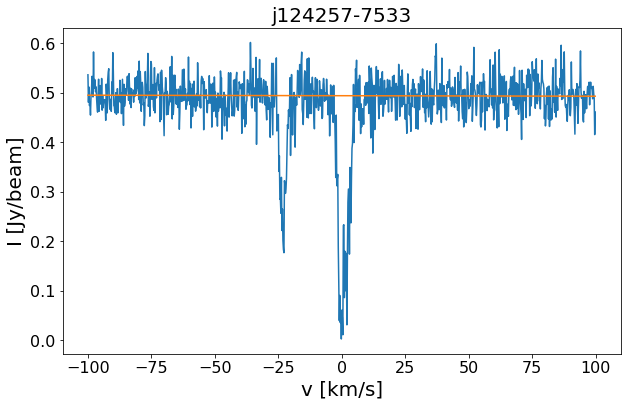

In [17]:
# fit the masked data:

pars_2 = np.polyfit(spectra_masked['velocity'], spectra_masked['intensity'], 1)
print(pars_2)

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra['intensity'])
plt.plot(spectra['velocity'], spectra['velocity']*pars_2[0]+pars_2[1])
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'I [Jy/beam]', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

In [18]:
# Comparing the results of the two fits:

print('Simple fit:', pars)
print('Masked fit:', pars_2)


Simple fit: [1.33326127e-05 4.79556882e-01]
Masked fit: [-1.03823654e-05  4.93592421e-01]


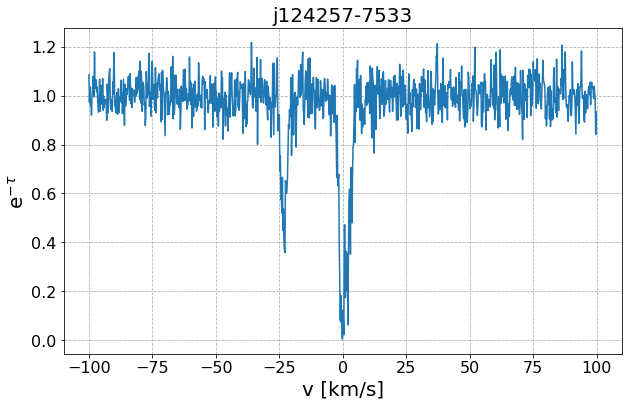

In [19]:
# Now we can devide the spectra wit the fitted continuum emission
spectra_etau = spectra['intensity']/pars_2[1]

# method 2:
continuum = spectra['intensity']*pars_2[0]+pars_2[1]
spectra_etau_2 = spectra['intensity']/continuum


fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.grid(True, linestyle = '--')
#plt.plot(spectra['velocity'],spectra_etau)
plt.plot(spectra['velocity'],spectra_etau_2)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
#plt.legend(fontsize=18)
plt.show()

## Fitting lines

In [20]:
from astropy import modeling

# Fitting Gaussians to the absorption lines

fitter = fitting.LevMarLSQFitter()
model = models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, spectra['velocity'], spectra_etau-1)

In [21]:
fitted_model

<Gaussian1D(amplitude=-0.8764641, mean=0.54327439, stddev=1.97011089)>

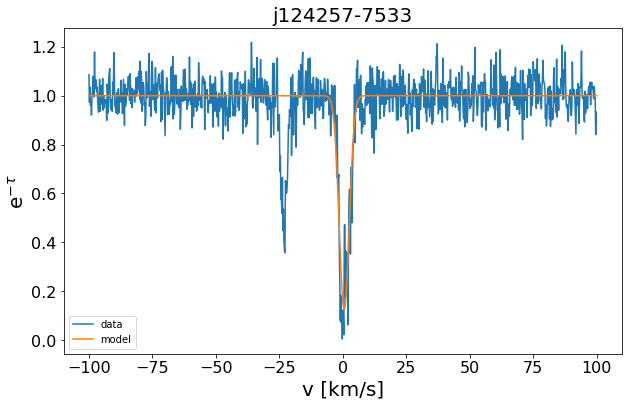

In [22]:
# First, fitting one of the lines

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra_etau, label = 'data')
plt.plot(spectra['velocity'], fitted_model(spectra['velocity'])+1, label = 'model')
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend()
#ax.set_xlim(-50, 50)
plt.show()

In [23]:
# fitting a model to both lines

gg_init = models.Gaussian1D(mean=0, amplitude=-1) + models.Gaussian1D(mean=-21, amplitude=-0.5)
fitted_model_2 = fitter(gg_init, spectra['velocity'], spectra_etau_2-1)
fitted_model_2

<CompoundModel(amplitude_0=-0.87646721, mean_0=0.54326183, stddev_0=1.97008199, amplitude_1=-0.55565425, mean_1=-23.19470436, stddev_1=1.17743528)>

In [24]:
print(fitted_model_2[0])
print(fitted_model_2[1])

params_1 = fitted_model_2[0].param_sets
params_2 = fitted_model_2[1].param_sets

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev     
    ------------------ ------------------ -----------------
    -0.876467210892486 0.5432618345208486 1.970081989178104
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              mean              stddev      
    ------------------- ------------------- ------------------
    -0.5556542487603633 -23.194704359080745 1.1774352789257931


In [32]:
# defining a Gaussian function, which we can use to plot the individual Gaussian components

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

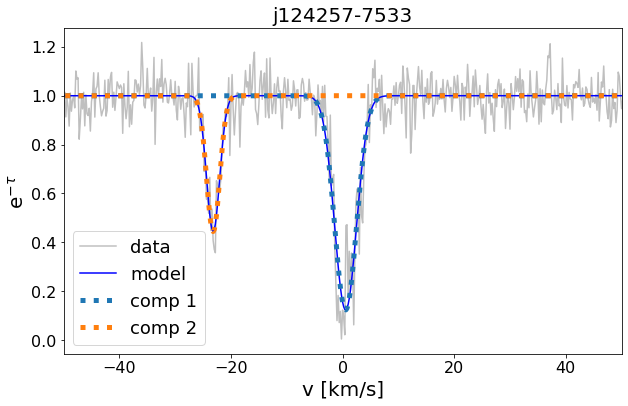

In [33]:
# plotting the result:

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra_etau_2, label='data', color='grey', alpha=0.5)
plt.plot(spectra['velocity'], fitted_model_2(spectra['velocity'])+1, label='model', color='blue')
plt.plot(spectra['velocity'], gauss(spectra['velocity'], params_1[0], params_1[1], params_1[2])+1, label='comp 1', linestyle=':', color='C0', lw=5)
plt.plot(spectra['velocity'], gauss(spectra['velocity'], params_2[0], params_2[1], params_2[2])+1, label='comp 2', linestyle=':', color='C1', lw=5)

ax.set_xlim(-50, 50)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=18)
plt.show()

In [34]:
# Calculate maximum optical depth

max_tau_1 = np.log(params_1[0] + 1) * -1
max_tau_2 = np.log(params_2[0] + 1) * -1

print('Maximum optical depth for feature 1', max_tau_1)
print('Maximum optical depth for feature 2', max_tau_2)

Maximum optical depth for feature 1 [2.09124866]
Maximum optical depth for feature 2 [0.8111523]


## Smoothing the data

In [36]:
# Convolving the data with a Gaussian kernel to smooth it

from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

kernel = Gaussian1DKernel(2)  # the number defines the width of the kernel, a higher number will result in a more agressive smoothing
spectra_etau_smooth = convolve(spectra_etau_2, kernel)


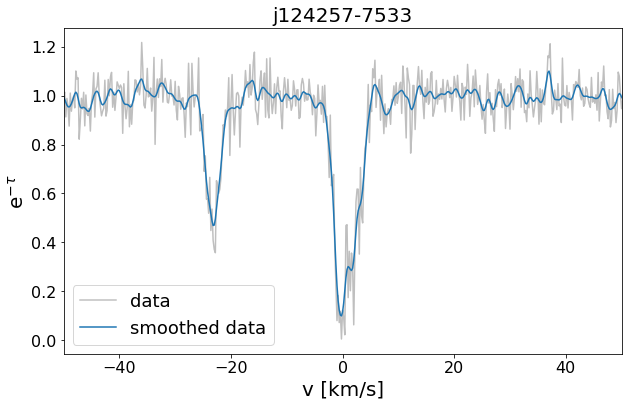

In [37]:
# plotting the resuls

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra_etau_2, label='data', color='grey', alpha=0.5)
plt.plot(spectra['velocity'], spectra_etau_smooth, label='smoothed data', color='C0')

ax.set_xlim(-50, 50)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=18)
plt.show()

# Find the location of the absorption peaks using the 2nd derivative of the spectra

1st derivative -> min and max at the edges of the line

2nd derivativ -> max. at the peak of the lines

In [38]:
# derivatives can be calculated with the np.gradient() function

grad_1 = np.gradient(spectra_etau_smooth)
grad_2 = np.gradient(np.gradient(spectra_etau_smooth))

print(np.where(np.max(grad_2) == grad_2))
loc = int(np.where(np.max(grad_2) == grad_2)[0])
print(spectra['velocity'][loc])

(array([495]),)
-0.999998291885


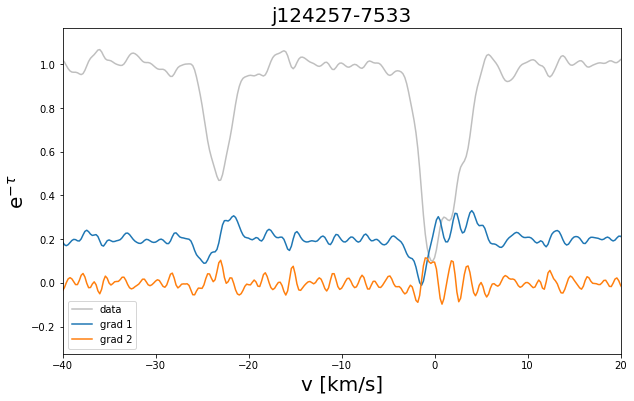

In [39]:
# plotting the results

fig, ax=plt.subplots(figsize = (10,6))
plt.title('j124257-7533', fontsize=20)
plt.plot(spectra['velocity'], spectra_etau_smooth, label='data', color='grey', alpha=0.5)
plt.plot(spectra['velocity'], grad_1*2+0.2, label='grad 1', color='C0')
plt.plot(spectra['velocity'], grad_2*5, label='grad 2', color='C1')

plt.legend()
ax.set_xlim(-40, 20)
ax.set_xlabel(r'v [km/s]', fontsize=20)
ax.set_ylabel(r'e$^{-\tau}$', fontsize=20)
plt.show()